## $I. Load Dataset:$

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [ ]:
#As previous report, we figure out 5 mong hundreds of codes. In this report, we chose VSN for the test:
path = '/content/gdrive/MyDrive/L/Data/df_VSN.csv'
df_VSN = pd.read_csv(path)
df_VSN.head()

,code,snapshot_date,open,high,low,close,nmVolume
0,VSN,2017-01-03,48.6,49.8,48.0,49.7,7500.0
1,VSN,2017-01-04,48.0,48.1,48.0,48.0,3200.0
2,VSN,2017-01-05,47.0,48.0,45.0,45.0,16900.0
3,VSN,2017-01-06,45.0,46.4,44.0,44.9,11800.0
4,VSN,2017-01-09,46.0,46.0,46.0,46.0,100.0


In [ ]:
df_VSN['snapshot_date'] = pd.to_datetime(df_VSN['snapshot_date'])

In [ ]:
df_VSN.shape

(1252, 7)

## $II. Preparation for Arima Model:$

In [ ]:
#Check Stationary for each code:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(df):
    result = adfuller(df.close)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
check_stationarity(df_VSN)
#With the Non-stationary, differencing is important

ADF Statistic: -1.989259
p-value: 0.291302
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Non-stationary


<Figure size 1080x576 with 0 Axes>

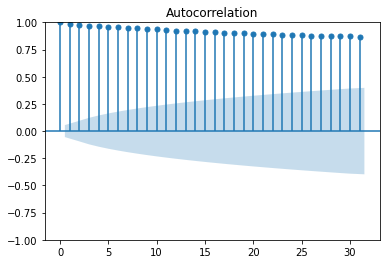

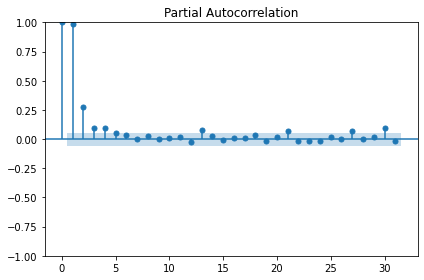

In [ ]:
#ACF and PACF plot for 5 codes: 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

def acf_pacf(sample): 
  plt.figure(figsize = (15,8))
  plot_acf(sample['close'])
  plot_pacf(sample['close'], method='ols')
  plt.tight_layout()
  plt.show()
acf_pacf(df_VSN)

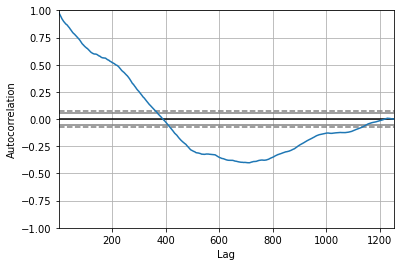

In [ ]:
#Autocorr plot: 
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_VSN['close'])
plt.show()

In [ ]:
#Import pmdarima model:
! pip install pmdarima 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.9 MB/s eta 0:00:00


In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
# Series = df_VSN[['snapshot_date','close']]
# Series = Series.set_index(['snapshot_date'])

In [ ]:
#Train & Test split:
train = df_VSN[:1000]
test = df_VSN[1001:]

In term of Arima model, defining 3 indexes p,d q is vital. What, and why p,d,q

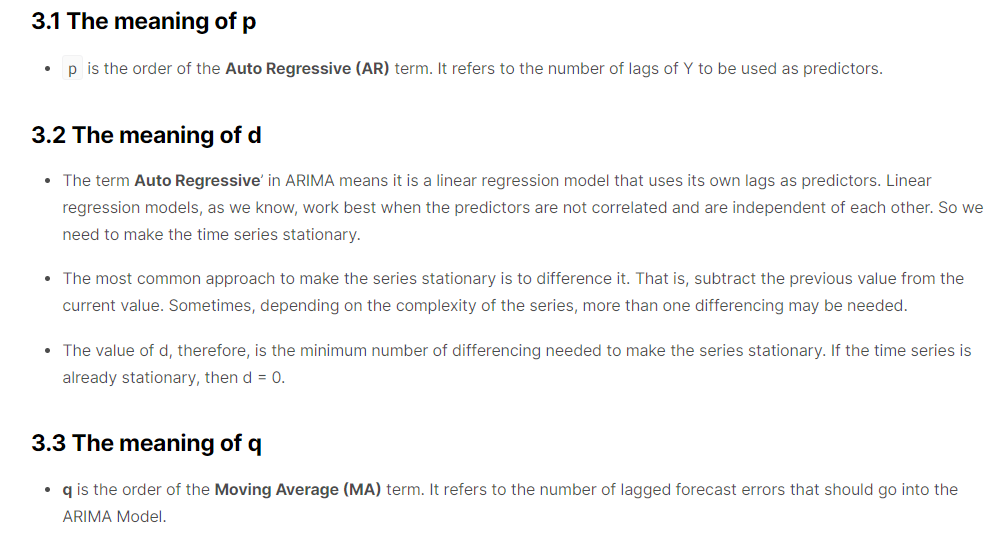

In [ ]:
#The auto Arima will automatically defining the best model:

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train['close'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=365,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())
#BEST model was: ARIMA(1,1,2)(0,0,0)[0]  

/usr/local/lib/python3.9/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (365) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3414.799, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3522.231, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3433.742, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3417.454, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3520.503, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3409.517, Time=1.90 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3426.615, Time=0.19 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3411.200, Time=0.92 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3410.757, Time=3.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3408.765, Time=3.98 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3416.686, Time=0.51 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3410.760, Time=2.71 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3412.546, Time=0.72 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3412.183, Time=4.69 sec
 ARIMA(1,1,2)(0,0,0)[0]          

We decided to apply the Auto Arima model, which will automatically choose the most proper index for ARIMA

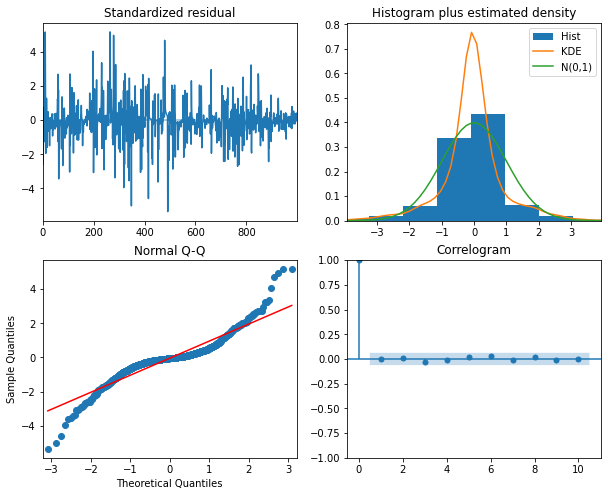

In [ ]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

***Interpretation of plots in plot diagnostics:***

**Standardized residual:** The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

**Histogram:** The density plot suggest normal distribution with mean slighlty shifted towards right.

**Theoretical Quantiles:** Mostly the dots fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

**Correlogram:** The Correlogram, (or ACF plot) shows the residual errors are not autocorrelated. The ACF plot would imply that there is some pattern in the residual errors which are not explained in the model. So we will need to look for more X’s (predictors) to the model.

In [ ]:
predict = pd.DataFrame(model.predict(n_periods = 365),index = test.index)
predict.columns = ['close']

#daily period so we may test with n_per = 12(monthly), 365(daily) or 1(yearly).

In [ ]:
predict.head()

,close
1001,26.269055
1002,26.242482
1003,26.220159
1004,26.201405
1005,26.185650


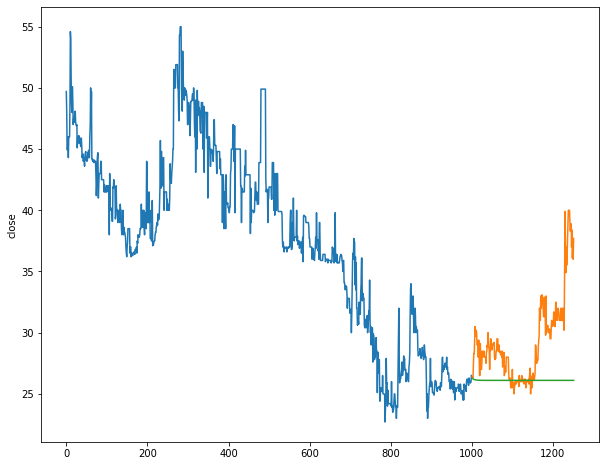

In [ ]:
#Plot for train, test and predict price: 

plt.figure(figsize = (10,8))
sns.lineplot(data = train, x = train.index, y = 'close')
sns.lineplot(data = test, x = test.index, y = 'close')
sns.lineplot(data = predict, x = predict.index, y='close')
plt.show()

It seems like the prediction is not good.

The commonly used accuracy metrics to judge forecasts are:

1. Mean Absolute Percentage Error (MAPE)
2. Mean Error (ME)
3. Mean Absolute Error (MAE)
4. Mean Percentage Error (MPE)
5. Root Mean Squared Error (RMSE)
6. Correlation between the Actual and the Forecast (corr)

Typically, 3 main metrics that are usually used are: MAPE, CORR and MINMAX.

In [ ]:
print('mape = ',np.mean(np.abs(predict.close - test.close)/np.abs(test.close)))
print('me = ', np.mean(predict.close - test.close))
print('mae = ', np.mean(np.abs(predict.close - test.close)))
print('mpe = ', np.mean((predict.close - test.close)/test.close))
print('rmse = ', np.mean((predict.close - test.close)**2)**.5)
print('corr = ', np.corrcoef(predict.close, test.close)[0,1])
mins = np.amin(np.hstack([predict.close[:,None], test.close[:,None]]))
maxs = np.amax(np.hstack([predict.close[:,None], 
                              test.close[:,None]]))
minmax = 1 - np.mean(mins/maxs)    
print('minmax = ',minmax)

mape =  0.1024729612774752
me =  -3.2113113418648944
mae =  3.303110101630775
mpe =  -0.0988797626589476
rmse =  4.678303318878823
corr =  -0.09643288256452152
minmax =  0.375


<ipython-input-23-dc540c1f81ab>:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([predict.close[:,None], test.close[:,None]]))
<ipython-input-23-dc540c1f81ab>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([predict.close[:,None],
<ipython-input-23-dc540c1f81ab>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test.close[:,None]]))


In [ ]:
# # Accuracy metrics
# def forecast_accuracy(forecast, actual):
#     mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
#     me = np.mean(forecast - actual)             # ME
#     mae = np.mean(np.abs(forecast - actual))    # MAE
#     mpe = np.mean((forecast - actual)/actual)   # MPE
#     rmse = np.mean((forecast - actual)**2)**.5  # RMSE
#     corr = np.corrcoef(forecast, actual)[0,1]   # corr
#     mins = np.amin(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     maxs = np.amax(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     minmax = 1 - np.mean(mins/maxs)             # minmax
#     acf1 = acf(fc-test)[1]                      # ACF1
#     return({'mape':mape, 'me':me, 'mae': mae, 
#             'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
#             'corr':corr, 'minmax':minmax})

# forecast_accuracy(predict['close'], test.values)

In [ ]:
smodel = pm.auto_arima(train['close'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=365,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # With Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(smodel.summary())

Performing stepwise search to minimize aic
